## 1) Crop on the coordinates point

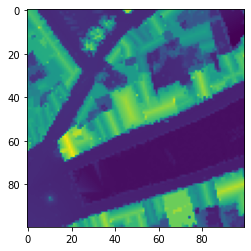

(1, 100, 100)

In [27]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import rasterio as rs
from rasterio.plot import show
from rasterio import Affine as A
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import Polygon
from rasterio.mask import mask
from rasterio.enums import Resampling
from tqdm import tqdm

%matplotlib inline

# enter of random downtown Bruges coordinates based on EPSG:31370 and square length edgelen
x, y, edgelen = 70190, 211947, 100  

#creation of the region of interest (roi), a square
roi = Polygon([(x - int(edgelen / 2), y + int(edgelen / 2)),
               (x + int(edgelen / 2), y + int(edgelen / 2)),
               (x + int(edgelen / 2), y - int(edgelen / 2)),
               (x - int(edgelen / 2), y - int(edgelen / 2))])


with rs.open('DHMVIIDSMRAS1m_k13\GeoTIFF\DHMVIIDSMRAS1m_k13.tif') as src:
    out_image, out_transform = rs.mask.mask(src, shapes=[roi],crop=True, filled = False)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rs.open("RGB_masked.tif", "w", **out_meta) as dest:
    dest.write(out_image)

show(out_image)
out_image.shape

## 2) 3D Plot of the DSM   

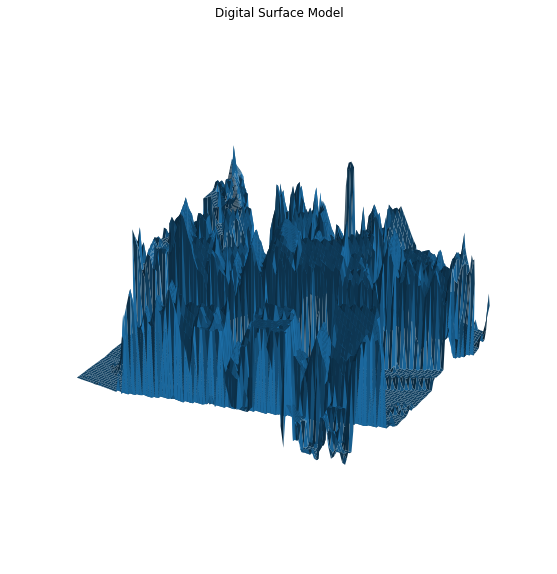

In [29]:
#Opening of the croped Tiff
with rs.open('RGB_masked.tif', 'r+') as mask:

    #creation of an array
    
    myarray2 = np.array(out_image)
    
    #getting rid of the NAN value and change to numerical value
    diff_surf = np.nan_to_num(myarray2)
    
    #Defining of x and y  
    temp_x = np.arange(diff_surf.shape[2])
    temp_y = np.arange(diff_surf.shape[1])
    
    #Fliping of y value
    temp_y = np.flip(temp_y,0)

    #Creation of the meshgrid
    X_diff, Y_diff = np.meshgrid(temp_x, temp_y)
    
    #Definition of Z layer
    Z_diff = diff_surf[0]

    # Plot DSM in Python
    fig_dsm = plt.figure(figsize = (10,10))

    ax = fig_dsm.add_subplot(111, projection = '3d')
    ax.axis('off')

    surf = ax.plot_surface(X_diff, Y_diff, Z_diff, rstride=1, cstride=1,linewidth=5)
    
    #limit of the Z height and plot of title
    ax.set_zlim3d(0,30)
    plt.title("Digital Surface Model")

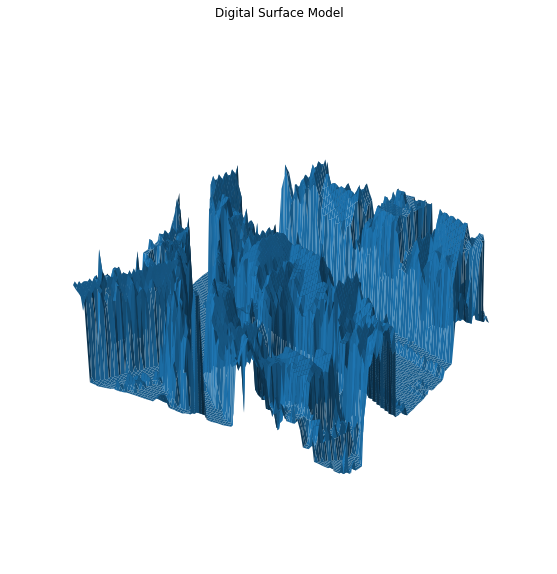

In [30]:
#Opening of the croped Tiff
with rs.open('RGB_masked.tif', 'r+') as mask:

    #creation of an array
    
    myarray2 = np.array(out_image)
    
    #getting rid of the NAN value and change to numerical value
    diff_surf = np.nan_to_num(myarray2)
    
    #Defining of x and y  
    temp_x = np.arange(diff_surf.shape[2])
    temp_y = np.arange(diff_surf.shape[1])
    
    #Fliping of y value
    #temp_y = np.flip(temp_y,0)

    #Creation of the meshgrid
    X_diff, Y_diff = np.meshgrid(temp_x, temp_y)
    
    #Definition of Z layer
    Z_diff = diff_surf[0]

    # Plot DSM in Python
    fig_dsm = plt.figure(figsize = (10,10))

    ax = fig_dsm.add_subplot(111, projection = '3d')
    ax.axis('off')

    surf = ax.plot_surface(X_diff, Y_diff, Z_diff, rstride=1, cstride=1,linewidth=5)
    
    #limit of the Z height and plot of title
    ax.set_zlim3d(0,30)
    plt.title("Digital Surface Model")

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5135.74it/s]


Text(0.5, 0.92, 'Drape image over DSM')

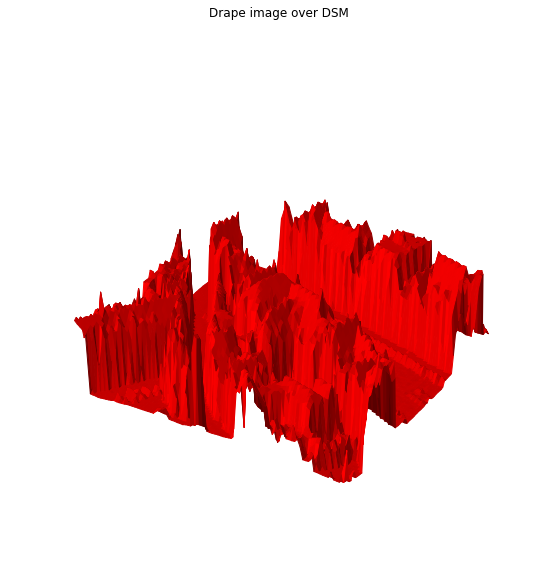

In [31]:
h = 1e-02
height = (Z_diff > h)

color_map = np.zeros([750, 925, 3], dtype=np.uint8)

for row_num in tqdm(range(len(height))):
    for col_num in range(len(height[row_num])):
        val = height[row_num][col_num]
        if (val==True):
            color_map[row_num, col_num, 0] = 255
            color_map[row_num, col_num, 1] = 0
            color_map[row_num, col_num, 2] = 0
        else:
            color_map[row_num, col_num, 0] = 0
            color_map[row_num, col_num, 1] = 255
            color_map[row_num, col_num, 2] = 0

# Plot Ground and non Ground
fig_classify = plt.figure(figsize = (10,10))

ax = fig_classify.add_subplot(111, projection = '3d')
ax.axis('off')

# To make RGB values in range of 0-1
drape_color = color_map/255
surf = ax.plot_surface(X_diff, Y_diff, Z_diff, rstride=1, cstride=1,facecolors=drape_color)

ax.set_zlim3d(0,40)
plt.title("Drape image over DSM")

In [ ]:
#draft
with rs.open('RGB_masked.tif', 'r+') as mask:

    #show(mask)
    
    myarray2 = np.array(mask)
            
    
    nslice,ny,nx = out_image.shape
    x = np.linspace(0, 51, nx)
    y = np.linspace(0, 51, ny)
    xv, yv = np.meshgrid(x, y)

    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    myarray3d=ax.plot_surface(xv,yv, nslice, cmap='afmhot')
    plt.show()

    ax.set_title('DSM')
    ax.set_zlabel('Elevation (m)')

# Register GDAL format drivers and configuration options with a
# context manager.
with rasterio.Env():

    # Write an array as a raster band to a new 8-bit file. For
    # the new file's profile, we start with the profile of the source
    profile = mask.profile

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        compress='lzw')

with rs.open('RGB_masked.tif', 'w', **profile) as dst:
    dst.write(array.astype(rasterio.uint8), 1)
    
with rasterio.open('RGB_masked.tif', 'r+') as mask:

    #show(mask)
    
    myarray2 = np.array(mask)
            
    print(myarray2)
    
    